# Fighting Fire with Data - Starter Notebook



# Setup

Make sure the files are available in the current directory. On Colab, upload them using the files tab on the left.

In [74]:
!ls *.csv # List files to check train, ss and test are present

SampleSubmission.csv  Test.csv	Train.csv  variable_definitions.csv


# Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb


# Understanding the Data

In [3]:
train = pd.read_csv('/kaggle/input/zindipredict-wildfires/Train.csv')
test = pd.read_csv('/kaggle/input/zindipredict-wildfires/Test.csv')
var_defs = pd.read_csv('/kaggle/input/zindipredict-wildfires/variable_definitions.csv')


In [3]:
# The training data.
var_defs = pd.read_csv('/kaggle/input/zindipredict-wildfires/variable_definitions.csv')
var_defs

,Variable,Description
0,ID,The IDs take the form of [area ID]_yyyy-mm-dd....
1,area,Area ID
2,date,The date that the data is aggregated over
3,lat,Latitude of the center of the area
4,lon,Longitude of the center of the area
5,burn_area,Percentage of the area burnt
6,climate_aet,"Actual evapotranspiration, derived using a one..."
7,climate_def,"Climate water deficit, derived using a one-dim..."
8,climate_pdsi,Palmer Drought Severity Index
9,climate_pet,Reference evapotranspiration (ASCE Penman-Mont...


In [5]:
# The training data.
train = pd.read_csv('/kaggle/input/zindipredict-wildfires/Train.csv')
train.head(5)

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2001-01-01,-15.858835,29.237029,0.0,1195,0,263,1195,206,10,...,0.0,0.0,0.018654,0.0,0.714446,0.012174,0.244890,0.009836,0.0,0.256932
1,1_2001-01-01,-15.858835,29.487029,0.0,1196,0,232,1196,201,10,...,0.0,0.0,0.000000,0.0,0.654783,0.000095,0.345121,0.000000,0.0,0.273093
2,2_2001-01-01,-15.858835,29.737029,0.0,1190,0,314,1190,192,10,...,0.0,0.0,0.000000,0.0,0.516421,0.000000,0.483579,0.000000,0.0,0.285109
3,3_2001-01-01,-15.858835,29.987029,0.0,1144,0,321,1144,186,66,...,0.0,0.0,0.000000,0.0,0.299000,0.163902,0.537098,0.000000,0.0,0.298418
4,4_2001-01-01,-15.858835,30.237029,0.0,1187,0,413,1187,186,9,...,0.0,0.0,0.000000,0.0,0.277392,0.067742,0.654866,0.000000,0.0,0.315621


In [8]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (83148, 29)
Test shape: (25584, 28)


This is a moderate-sized dataset → big enough for tree-based models like XGBoost/LightGBM, but small enough for us to experiment quickly.

Explore Target Variable — burn_area

Now we’ll analyze how much land is burned.

In [9]:
# Split the ID (eg 127_2017-01-03) to get the date string, which we convert to datetime to make life easier
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
test['date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[1]))

## Time series breakdown
Are fires more likely in certain seasons (e.g. dry season)?

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


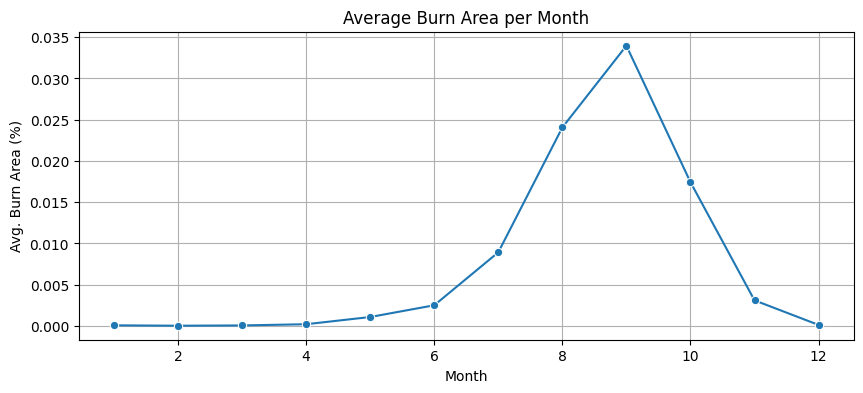

In [10]:
# Convert date column
train['date'] = pd.to_datetime(train['date'])

# Extract month and year
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month

# Average burn area by month
monthly_burn = train.groupby('month')['burn_area'].mean().reset_index()

plt.figure(figsize=(10,4))
sns.lineplot(data=monthly_burn, x='month', y='burn_area', marker='o')
plt.title("Average Burn Area per Month")
plt.xlabel("Month")
plt.ylabel("Avg. Burn Area (%)")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


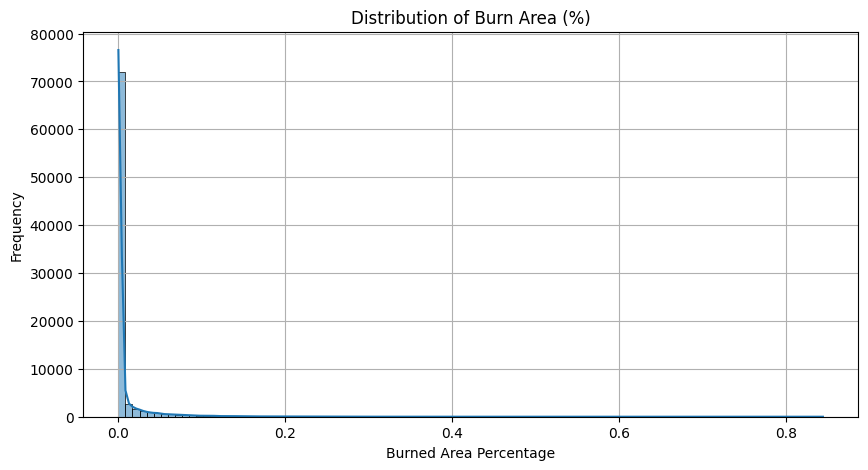

In [11]:


# Plot distribution of burn_area
plt.figure(figsize=(10,5))
sns.histplot(train['burn_area'], bins=100, kde=True)
plt.title('Distribution of Burn Area (%)')
plt.xlabel('Burned Area Percentage')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


 histogram shows extreme skewness:

Most values are zero or near-zero (areas without fire).

Very few rows have large burned percentages.

This tells us:

The problem is imbalanced regression.

Models may learn to predict zero too often unless we handle the skew (e.g. log-transform or resampling).

This tells us whether we are dealing with:

A highly imbalanced regression problem (most areas not burned)

Or a wide spread of values

In [12]:
print("Zero burn area rows:", (train['burn_area'] == 0).sum())
print("Non-zero burn area rows:", (train['burn_area'] > 0).sum())


Zero burn area rows: 63725
Non-zero burn area rows: 19423


Any correlations  with climate features

In [4]:
# Only numeric columns
num_cols = train.select_dtypes(include=['float64', 'int64']).columns

# Drop ID and lat/lon
features = [col for col in num_cols if col not in ['burn_area', 'lat', 'lon']]
corrs = train[features + ['burn_area']].corr()['burn_area'].sort_values(ascending=False)

# Show top positive and negative correlations
print("Top Positive Correlations:\n", corrs.head(10))
print("\nTop Negative Correlations:\n", corrs.tail(10))


Top Positive Correlations:
 burn_area       1.000000
climate_def     0.279511
climate_vs      0.261562
climate_vpd     0.219974
climate_pet     0.168871
climate_srad    0.160517
landcover_5     0.151957
elevation       0.074576
climate_tmmx    0.040500
landcover_4     0.013846
Name: burn_area, dtype: float64

Top Negative Correlations:
 landcover_7     -0.027734
climate_ro      -0.071414
landcover_6     -0.075815
climate_soil    -0.089246
climate_tmmn    -0.099436
precipitation   -0.169218
climate_pr      -0.170532
climate_aet     -0.211806
climate_vap     -0.221348
climate_swe           NaN
Name: burn_area, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


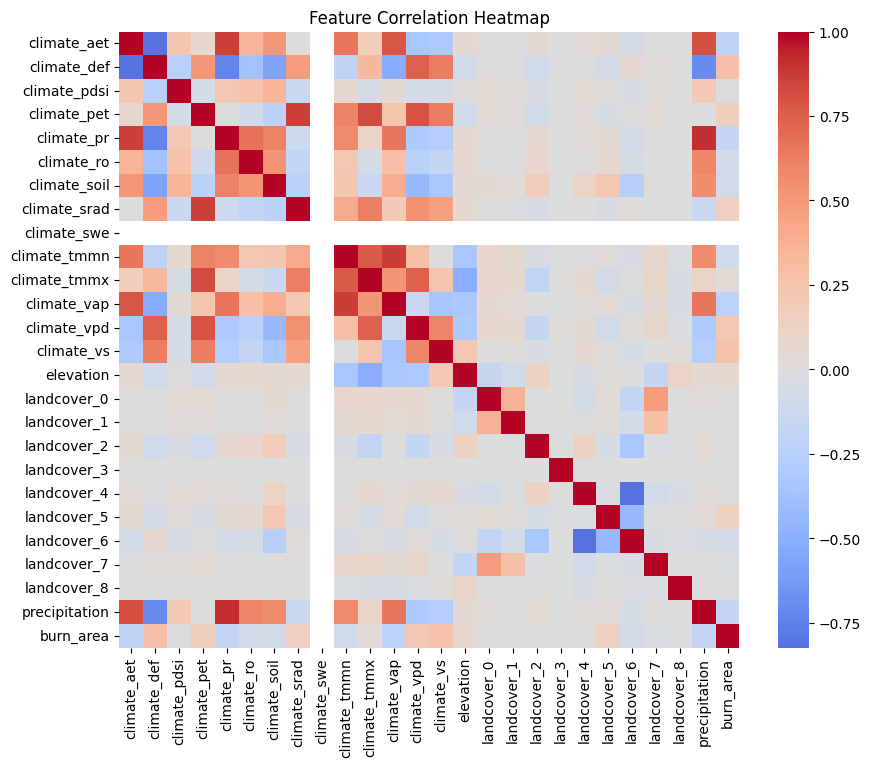

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(train[features + ['burn_area']].corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


Climate features are correlated with each other (e.g., evapotranspiration vs. precipitation vs. soil moisture).

Some positive relationships with burn_area show up (likely temperature, vapor pressure deficit).

Some negative relationships with burn_area (soil moisture, precipitation).


This makes sense scientifically:

Drought (low soil moisture, low rainfall) + heat + wind → more fire.

Wet conditions suppress fires.

# Data Preprocessing

In [6]:
train.isnull().sum().sort_values(ascending=False).head(10)


ID             0
climate_vap    0
landcover_8    0
landcover_7    0
landcover_6    0
landcover_5    0
landcover_4    0
landcover_3    0
landcover_2    0
landcover_1    0
dtype: int64

 since burn area is skweness so try some log transform

What Is Skewness?
A normal distribution exhibits zero skewness and is often shown as a bell curve. Skewness is the degree of asymmetry observed in a set of data. A distribution is right-skewed if the mean is higher than the median, and left-skewed if the mean is below the median.

Skewness is detrimental to many machine learning models because it creates an asymmetrical distribution where the data is concentrated on one side, pulling the mean away from the median and mode.
 This imbalance can bias predictions, particularly in regression models, where the model may overpredict due to the influence of extreme values in the tail.
 Skewed data can also lead to overfitting, especially in deep learning with small datasets, as the model may focus excessively on the majority class or outliers, resulting in poor generalization to unseen data.
 Furthermore, skewness can distort key performance metrics like accuracy, precision, and recall, making it difficult to accurately evaluate model performance, especially in classification tasks where the model may favor the majority class.


In [7]:

train['burn_area_log'] = np.log1p(train['burn_area'])  # log(1+x)


Feature Engineering (basic for now)

Convert date into:

Drop ID, lat, lon for now (we’ll reconsider later).

Keep all climate + landcover + elevation + precipitation.

In [12]:


train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

test['date'] = pd.to_datetime(test['date'])
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


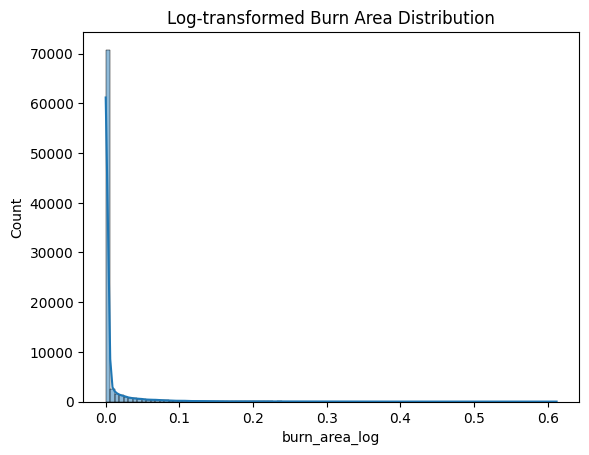

In [13]:
sns.histplot(train['burn_area_log'], bins=100, kde=True)
plt.title("Log-transformed Burn Area Distribution")
plt.show()


In [14]:
# Drop ID column
train = train.drop(columns=['ID'])
test = test.drop(columns=['ID'])

# Convert date column
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# Add time features
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year

# Drop raw date now (optional, since we extracted month/year)
train = train.drop(columns=['date'])
test = test.drop(columns=['date'])


In [15]:
# Target
y = train['burn_area_log']

# Drop targets from train
X = train.drop(columns=['burn_area', 'burn_area_log'])


### Scaling 
tree based models do not need scaling but linear models numeric models do need scaling

In [17]:


num_cols = X.select_dtypes(include=['float64','int64']).columns
scaler = StandardScaler()

X[num_cols] = scaler.fit_transform(X[num_cols])
test[num_cols] = scaler.transform(test[num_cols])


### Baseline Model

In [19]:


# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_val)

# Back-transform (exp) for RMSE in original scale
rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
print("Validation RMSE:", rmse)


Validation RMSE: 0.021255533094603627


## Improving Model

1. Feature Importance

Let’s see what Random Forest thinks are important features:

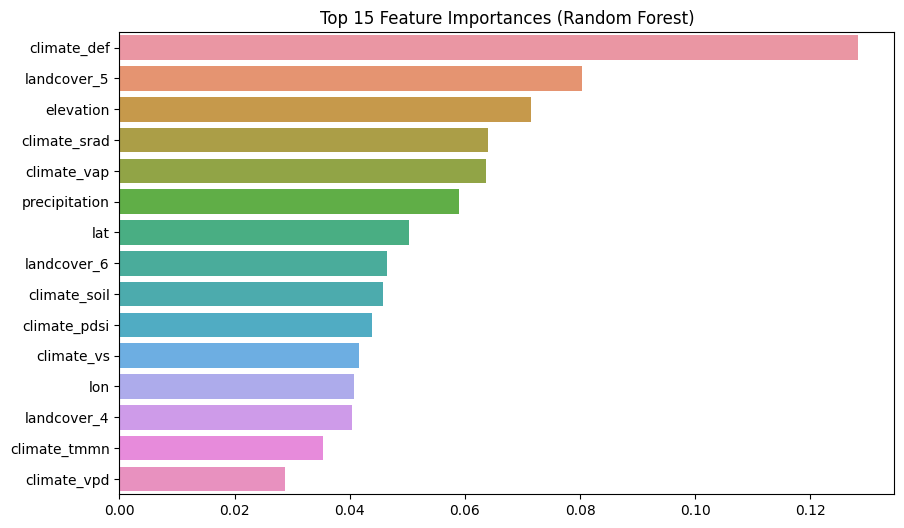

In [20]:
importances = rf.feature_importances_
feat_names = X.columns

# Sort
indices = np.argsort(importances)[::-1]

# Top 15
plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices[:15]], y=feat_names[indices[:15]])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


Do climate variables dominate? (likely yes)

Are month/season useful?

Is landcover contributing?

# LightGBM (fast, handles large data well)

XGBoost (powerful but slower)

In [28]:
# Dataset
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_val, label=y_val)

# Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

# Callbacks for early stopping and verbose evaluation
callbacks = [
    lgb.early_stopping(stopping_rounds=5, verbose=True),
    lgb.log_evaluation(period=100)
]

# Train with callbacks
lgb_model = lgb.train(params, dtrain, valid_sets=[dtrain, dval],
                      num_boost_round=1000, callbacks=callbacks)

# Predictions
y_pred_lgb = lgb_model.predict(X_val)
rmse_lgb = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred_lgb)))
print("LightGBM Validation RMSE:", rmse_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5429
[LightGBM] [Info] Number of data points in the train set: 66518, number of used features: 27
[LightGBM] [Info] Start training from score 0.007353
Training until validation scores don't improve for 5 rounds
[100]	training's rmse: 0.0176287	valid_1's rmse: 0.0190061
Early stopping, best iteration is:
[175]	training's rmse: 0.0163859	valid_1's rmse: 0.0187212
LightGBM Validation RMSE: 0.021410501481649413


# Feature Engineering

Water balance: rainfall minus evapotranspiration
Dryness indicator: vapor pressure deficit × temperature
Temperature range: difference between max and min

In [30]:
train['water_balance'] = train['climate_pr'] - train['climate_pet']
test['water_balance'] = test['climate_pr'] - test['climate_pet']


In [31]:
train['temp_range'] = train['climate_tmmx'] - train['climate_tmmn']
test['temp_range'] = test['climate_tmmx'] - test['climate_tmmn']


In [32]:
train['dryness'] = train['climate_vpd'] * train['climate_tmmx']
test['dryness'] = test['climate_vpd'] * test['climate_tmmx']


3. Landcover Simplification

There are 9 landcover percentages (they sum to ~1).
You can compress into main categories:

In [33]:


# Vegetation cover (all vegetation types)
veg_cols = [f'landcover_{i}' for i in range(1,7)]
train['veg_cover'] = train[veg_cols].sum(axis=1)
test['veg_cover'] = test[veg_cols].sum(axis=1)

# Built-up / Urban
train['urban'] = train['landcover_8']
test['urban'] = test['landcover_8']

# Water
train['water'] = train['landcover_0']
test['water'] = test['landcover_0']

In [36]:
# 5. Spatial Features (lat/lon grouping)

# Instead of raw lat, lon, create region bins:

train['lat_bin'] = (train['lat']*10).round(0)
train['lon_bin'] = (train['lon']*10).round(0)

test['lat_bin'] = (test['lat']*10).round(0)
test['lon_bin'] = (test['lon']*10).round(0)


# This groups areas into ~0.1° regions (≈ 11 km grid).
# Wildfires often cluster spatially.

In [37]:
print("Train shape after FE:", train.shape)


Train shape after FE: (83148, 39)


In [41]:
# Dataset
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_val, label=y_val)

# Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

# Callbacks for early stopping and verbose evaluation
callbacks = [
    lgb.early_stopping(stopping_rounds=5, verbose=True),
    lgb.log_evaluation(period=100)
]

# Train with callbacks
lgb_model = lgb.train(params, dtrain, valid_sets=[dtrain, dval],
                      num_boost_round=1000, callbacks=callbacks)

# Predictions
y_pred_lgb = lgb_model.predict(X_val)
rmse_lgb = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred_lgb)))
print("LightGBM Validation RMSE:", rmse_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5429
[LightGBM] [Info] Number of data points in the train set: 66518, number of used features: 27
[LightGBM] [Info] Start training from score 0.007353
Training until validation scores don't improve for 5 rounds
[100]	training's rmse: 0.0176287	valid_1's rmse: 0.0190061
Early stopping, best iteration is:
[175]	training's rmse: 0.0163859	valid_1's rmse: 0.0187212
LightGBM Validation RMSE: 0.021410501481649413


# Submission File

In [ ]:
# Predict test
test_preds = lgb_model.predict(test)

# Back-transform
test_preds_final = np.expm1(test_preds)

# Submission file
submission = pd.DataFrame({
    'ID': pd.read_csv('/kaggle/input/zindipredict-wildfires/test.csv')['ID'],
    'burn_area': test_preds_final
})

submission.to_csv('submission.csv', index=False)
